In [40]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.utils import plot_model

from utils import *

# for Robust location estimation
from statsmodels import robust
import statsmodels.api as sm
from astropy.stats import biweight_location

tf.random.set_seed(25)

In [41]:
prices = pd.read_csv("data/SX5E/close_mat.csv")

In [42]:
X = prices.iloc[:, [1, 3]]

In [43]:
X

,URW NA Equity,LIN GY Equity
0,132.500000,177.550003
1,132.500000,177.550003
2,132.500000,177.550003
3,130.600006,174.449997
4,130.949997,169.350006
...,...,...
6489,NaN,23.549999
6490,NaN,23.549999
6491,NaN,23.549999
6492,NaN,23.400000


<Axes: >

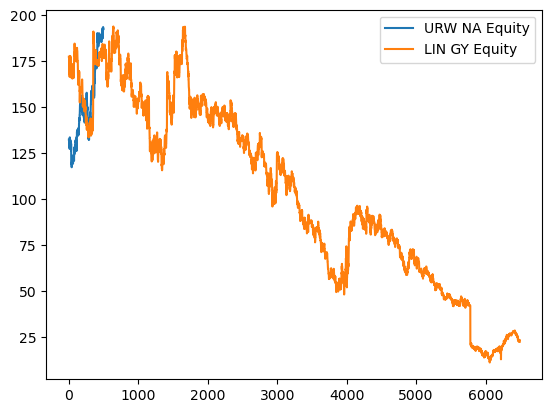

In [44]:
X.plot()

<Axes: >

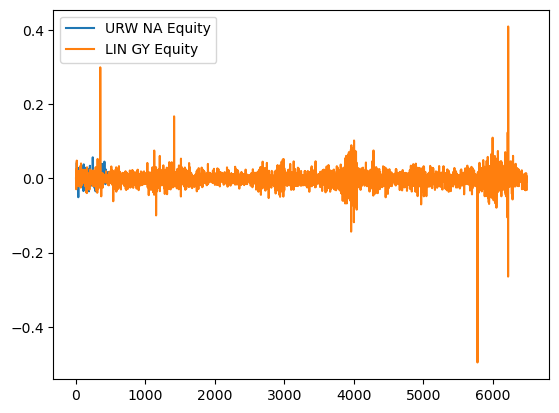

In [45]:
X_ret = price_to_returns(X)
X_ret.plot()

<Axes: >

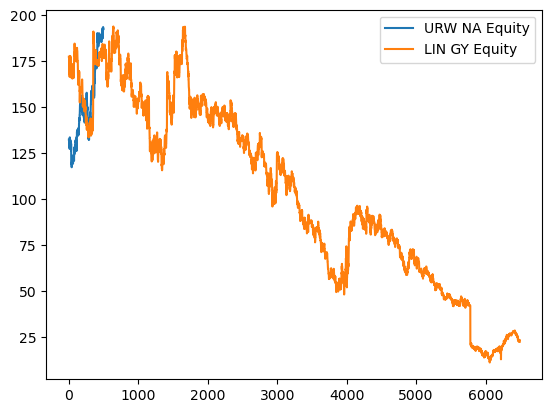

In [46]:
X_cum_ret = cumulative_returns(X_ret, start=list(X.iloc[0, :]))
X_cum_ret.plot()

<Axes: >

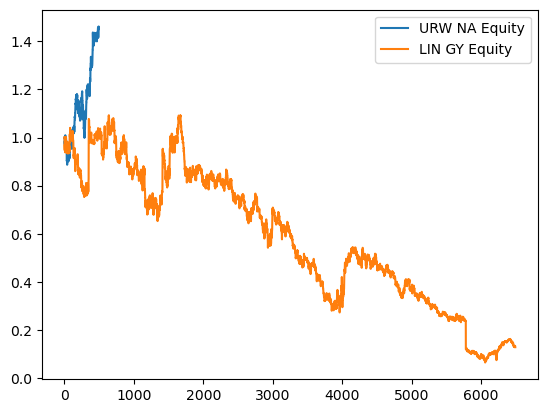

In [47]:
X_cum_ret = cumulative_returns(X_ret)
X_cum_ret.plot()

In [48]:
X

,URW NA Equity,LIN GY Equity
0,132.500000,177.550003
1,132.500000,177.550003
2,132.500000,177.550003
3,130.600006,174.449997
4,130.949997,169.350006
...,...,...
6489,NaN,23.549999
6490,NaN,23.549999
6491,NaN,23.549999
6492,NaN,23.400000


In [51]:
price_to_returns(X, log=True)

,URW NA Equity,LIN GY Equity
0,NaN,NaN
1,0.000000,0.000000
2,0.000000,0.000000
3,-0.014443,-0.017614
4,0.002676,-0.029671
...,...,...
6489,NaN,0.001062
6490,NaN,0.000000
6491,NaN,0.000000
6492,NaN,-0.006390


In [52]:
np.log((X / X.shift(1)))

,URW NA Equity,LIN GY Equity
0,NaN,NaN
1,0.000000,0.000000
2,0.000000,0.000000
3,-0.014443,-0.017614
4,0.002676,-0.029671
...,...,...
6489,NaN,0.001062
6490,NaN,0.000000
6491,NaN,0.000000
6492,NaN,-0.006390


In [53]:
X

,URW NA Equity,LIN GY Equity
0,132.500000,177.550003
1,132.500000,177.550003
2,132.500000,177.550003
3,130.600006,174.449997
4,130.949997,169.350006
...,...,...
6489,NaN,23.549999
6490,NaN,23.549999
6491,NaN,23.549999
6492,NaN,23.400000


In [56]:
(X.dropna()).prod()

C:\Users\lucat\anaconda3\envs\AI_LAB\lib\site-packages\numpy\core\_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)


URW NA Equity    inf
LIN GY Equity    inf
dtype: float64

In [59]:
X_ret.dropna().prod()

URW NA Equity   -0.0
LIN GY Equity   -0.0
dtype: float64

In [65]:
X_ret +1

,URW NA Equity,LIN GY Equity
0,NaN,NaN
1,1.00000,1.000000
2,1.00000,1.000000
3,0.98566,0.982540
4,1.00268,0.970765
...,...,...
6489,NaN,1.001063
6490,NaN,1.000000
6491,NaN,1.000000
6492,NaN,0.993631
